**CRIB SHEET RULES OF THE ROAD:**

This crib sheet is provided to support access, utilization, and plotting of UCalgary optical datasets. It is intended as a base set of code that a user may edit and manipulate to serve their own needs.  Crib sheets contains UCalgary verified and validated procedures for plotting and manipulating UCalgary ASI data for common use cases.  Use of this crib sheet does not require acknowledgment, it is freely distributed for scientific use. Please also remember to perform due diligence on all data use.  We recommend comparison with verified data products on [data.phys.ucalgary.ca](https://data.phys.ucalgary.ca) to ensure that any user output does not contradict operational summary plots.  Data use must be acknowledged according to the information available for each data set - please see [data.phys.ucalgary.ca](https://data.phys.ucalgary.ca).  If you encounter any issues with the data or the crib sheet, please contact the UCalgary team for support (Emma Spanswick, elspansw@ucalgary.ca). Copyright © University of Calgary.

---
# **Loading, Calibrating, and Plotting Single Channel ASI Data**
---

### **Datasets**

In a digital All-Sky Imager (ASI), an optical system (fisheye lens, filters, etc.) projects an image of the full ('2$\pi$ sky') onto the plane of a detector (CCDs, CMOS, or other). For a single 'capture', the output is an image, with each pixel corresponding to an azimuth and elevation. Data numbers within the image convey information about the brightness of the sky in the respective directions. That information might be simply related to brightness in a narrow wavelength band (e.g., REGO, TREx Blueline, TREx NIR, a NASCAM channel, etc.), or related in a more complex way to brightness across broad ranges of wavelengths (e.g., THEMIS ASI, TREx RGB).

Datasets from UCalgary geospace remote sensing projects can be found at https://data.phys.ucalgary.ca. This crib sheet pertains to single channel systems:
- THEMIS ASI
- REGO
- TREx NIR
- TREx Blueline
- NORSTAR NASCAM

### **Crib Sheet Summary**
The code and supporting documentation in this file outlines the basics of working with our single-channel ASI data, specifically outlining
- Loading data
- Displaying single images
- Generating a movie
- Using image data to create keograms and ewograms
- Applying dark frame corrections to image data
- Applying flat field and radiometric calibrations to image data


</br>

---

</br>


## Install dependencies

Here we'll install [PyAuroraX](https://github.com/aurorax-space/pyaurorax), and import it.

Some helpful links:
  - [PyAuroraX documentation](https://docs.aurorax.space/code/overview)
  - [PyAuroraX API Reference](https://docs.aurorax.space/code/pyaurorax_api_reference/pyaurorax)
  - [Jupyter notebook examples](https://github.com/aurorax-space/pyaurorax/tree/main/examples/notebooks)


In [1]:
!pip install pyaurorax

In [2]:
import datetime
import numpy as np
import pyaurorax

aurorax = pyaurorax.PyAuroraX()
at = aurorax.tools

## Downloading Data

We need to download the data we're going to be using. PyAuroraX provides functions to handle this for you. You can learn more about how to use them by looking at the 'Data download` crib sheet, reading the PyAuroraX documentation, or the PyAuroraX API reference. Links are above.

If you prefer our other methods to download the data (basic HTTP, FTP, Rsync), that is also possible. You would download the data and skip to the data reading step of this crib sheet.

In [3]:
# First, we're going to download an hour of REGO full-resolution raw data, specifically 2023-02-04 UT06 from
# the camera in Gillam, MB.
dataset_name = "REGO_RAW"
start_dt = datetime.datetime(2023, 2, 24, 6, 0)
end_dt = datetime.datetime(2023, 2, 24, 6, 59)
site_uid = "gill"
r = aurorax.data.ucalgary.download(dataset_name, start_dt, end_dt, site_uid=site_uid)

In [4]:
# Second, we're going to download a few calibration files for REGO
r_ray = aurorax.data.ucalgary.download_best_rayleighs_calibration("REGO_CALIBRATION_RAYLEIGHS_IDLSAV", "652", timestamp=start_dt)
print(r_ray.filenames)
r_flat = aurorax.data.ucalgary.download_best_flatfield_calibration("REGO_CALIBRATION_FLATFIELD_IDLSAV", "652", timestamp=start_dt)
print(r_flat.filenames)

[PosixPath('/home/darrenc/pyaurorax_data/REGO_CALIBRATION_RAYLEIGHS_IDLSAV/REGO_Rayleighs_15652_20141102-+_v01.sav')]
[PosixPath('/home/darrenc/pyaurorax_data/REGO_CALIBRATION_FLATFIELD_IDLSAV/REGO_flatfield_15652_20141102-+_v01.sav')]


## **Reading Data**

In [5]:
# To begin, let's read a single minute's worth of REGO data, specifically 2023/02/24 06:21 UTC, at Gillam, MB, Canada.
#
# Note: In general, UCalgary ASI data is stored in one minute files. A file contains 'stacked' images, each with its own metadata.
#       Depending on the imaging cadence there will be more or less images in the same file.

# set the filename
image_path = r.filenames[21]  # we're going to choose the 21st minute file
print(r.filenames[21])
print()

# read the data
data = aurorax.data.ucalgary.read(r.dataset, image_path)
data.pretty_print()

/home/darrenc/pyaurorax_data/REGO_RAW/2023/02/24/gill_rego-652/ut06/20230224_0621_gill_rego-652_6300.pgm.gz

Data:
  data                  : array(dims=(512, 512, 20), dtype=uint16)
  timestamp             : [20 datetimes]
  metadata              : [20 dictionaries]
  problematic_files     : []
  calibrated_data       : None
  dataset               : Dataset(name=REGO_RAW, short_description='REGO All Sky Imagers 3-sec raw da...)


The `data` attribute of the returned Data object contains the loaded image data for the file read, stored as a NumPy array. For a single 1-minute datafile, this NumPy array will contain some number of images - in the case of REGO, which has an imaging cadence of 3 seconds, a single file will usually contain 20 images.

For a single channel image, the first two dimensions will give you the size of an actual image, whereas the last will tell you the number of images/frames.

The `timestamp` attribute will contain datetime objects corresponding to the time of each image loaded. The `metadata` field will have additional metadata for each image.

<small>*Note: The last dimension of an image data array will **always** tell you how many images it contains.*</small>

---

## **Plotting Single Images**

Important note about image orientation. Although we do our best to make sure instruments are aligned as the readfiles expect, there are times for some imagers for which images will appear flipped horizontally or vertically when read in. There are several ways to validate the orientation of an image. For example, you can watching the behavior of celestial objects in the imager FOV to determine cardinal directions. You can also view the summary movies available for some ASIs on the [Data Portal website](https://data-portal.phys.ucalgary.ca). 

In most cases, the data will be oriented properly, but it's always good to keep this in mind when working with the data.

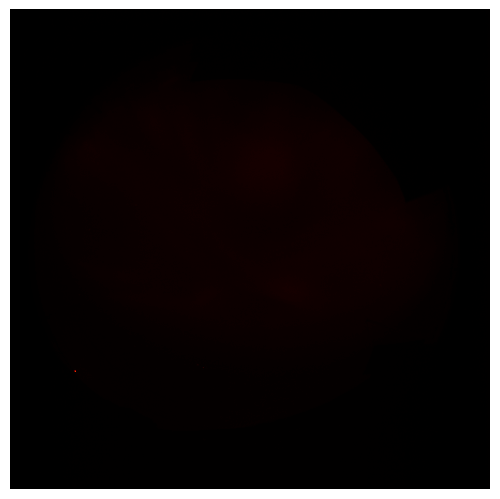

In [6]:
# A single image can be obtained by slicing the image array - let's plot the first image
at.display(data.data[:,:,0], cmap="gist_heat")

Notice, this image is quite dark. This is because in general, auroral phenomena will not use the full dynamic range of of the detector. Depending on the type of camera, or the phenomena you are interested in, you may wish to scale the data differently. We can manually scale the brightness up for plotting purposes, using the following function.

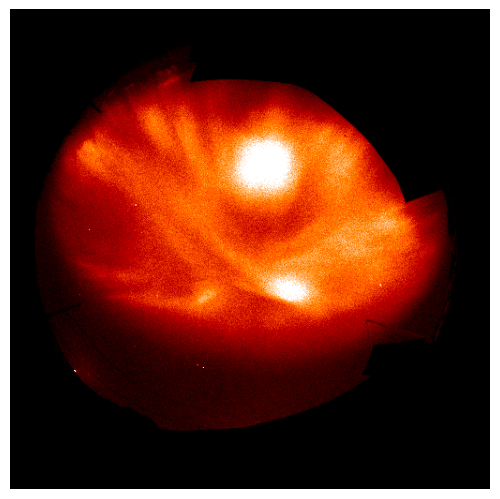

In [7]:
# Now, let's scale all the images
images_scaled = at.scale_intensity(data.data, min=400, max=1100)

# and then display the first image again
at.display(images_scaled[:,:,0], cmap="gist_heat")

**NOTE**

Depending on the imager and the type of activity in the FOV, you will need to play around with the scaling floor and ceiling in order to achieve the desired result.

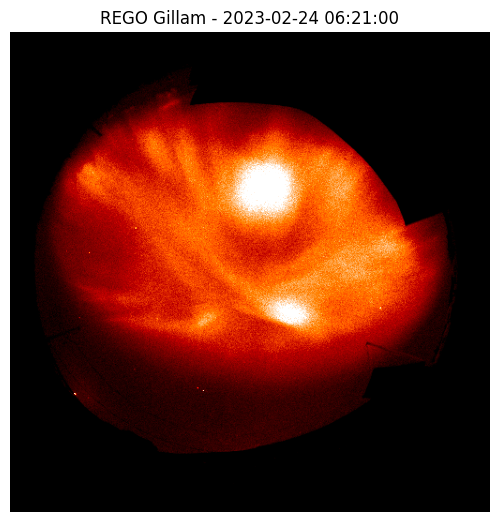

In [8]:
# Next is often useful to include some information about the image itself. This
# can be done easily using the display function and the metadata
at.display(images_scaled[:,:,0], title="REGO Gillam - %s" % (data.timestamp[0].strftime("%Y-%m-%d %H:%M:%S")), cmap="gist_heat")

---

## **Generate a Movie**

Now, with the ability to display single image data arrays, one can generate a time series movie of the ASI data. Let's generate a movie with a high temporal resolution, generating a frame for every 3 seconds of data (same cadence that REGO images at), for 10 minutes of data.

To do this, we create a series of image files the way we want them to be, then pass those filenames to the `movie()` function.


In [9]:
# first up, let's read in the whole hour of data that we previously downloaded
data = aurorax.data.ucalgary.read(r.dataset, r.filenames, n_parallel=2)
data.pretty_print()

Data:
  data                  : array(dims=(512, 512, 1200), dtype=uint16)
  timestamp             : [1200 datetimes]
  metadata              : [1200 dictionaries]
  problematic_files     : []
  calibrated_data       : None
  dataset               : Dataset(name=REGO_RAW, short_description='REGO All Sky Imagers 3-sec raw da...)


In [10]:
# second, we'll scale all the images
images_scaled = at.scale_intensity(data.data, min=400, max=1100)

In [11]:
# Next, we'll to process all frames from the hour to generate the PNG files on
# disk. Using the display() function we have it return the figure, then add some 
# timestamp and other text to our liking. Finally, saving it to disk.
#
# We are going to utilize multiprocessing and tqdm's progress bar to do this quickly,
# farming the frames out to several worker processes.

import os
import platform
import matplotlib.pyplot as plt
from tqdm.contrib.concurrent import process_map as tqdm_process_map
from tqdm.auto import tqdm


def process_frame(i):
    fig, ax = at.display(images_scaled[:, :, i], cmap="gray", returnfig=True)
    ax.text(5, 240, "THEMIS ASI", color="white", size=14)
    ax.text(5, 225, "ATHA", color="white", size=14)
    ax.text(145, 8, data.timestamp[i].strftime("%Y-%m-%d %H:%M:%S UTC"), color="white", size=11)
    filename = "movie_frames/%s_atha_themis.png" % (data.timestamp[i].strftime("%Y%m%d_%H%M%S"))
    os.makedirs(os.path.dirname(filename), exist_ok=True)
    plt.savefig(filename, bbox_inches="tight")
    plt.close()
    return filename


if (platform.system() == "Windows"):
    # pre-process frames serially
    #
    # NOTE: multiprocessing on Windows from within a notebook is non-trivial, so we'll
    # just do this serially for simplicity sake.
    frame_filename_list = []
    for i in tqdm(range(0, images_scaled.shape[-1]), total=images_scaled.shape[-1], desc="Generating frame files: ", unit="frames"):
        frame_filename_list.append(process_frame(i))
else:
    frame_filename_list = tqdm_process_map(
        process_frame,
        range(0, images_scaled.shape[-1]),
        max_workers=5,
        chunksize=1,
        desc="Generating frame files: ",
        unit="frames",
    )

Generating frame files:   0%|          | 0/1200 [00:00<?, ?frames/s]

In [12]:
# now that we have our frames, we'll generate a movie using them
at.movie(frame_filename_list, "test.mp4", n_parallel=5)

Reading files:   0%|          | 0/1200 [00:00<?, ?files/s]

Encoding frames:   0%|          | 0/1200 [00:00<?, ?frames/s]

In [ ]:
# cleanup
import shutil
shutil.rmtree("movie_frames", ignore_errors=True)
if os.path.exists("test.mp4"): 
    os.remove("test.mp4")

---

## **Create and Display Keograms**

Keograms are a useful data product that can be generated from ASI image data. A keogram is created by stacking slices of the middle column (a N-S slice for the orientation of the UCalgary imagers) of pixels from ASI images over a period of time. The below code walks through the creation of a 1 hour keogram created from REGO data, for 2023/02/24 UT06 at Gillam, MB, Canada.


Keogram(data=array(dims=(512, 1200), dtype=uint16), timestamp=[1200 datetime objects], ccd_y=array(512 values), mag_y=None, geo_y=None)


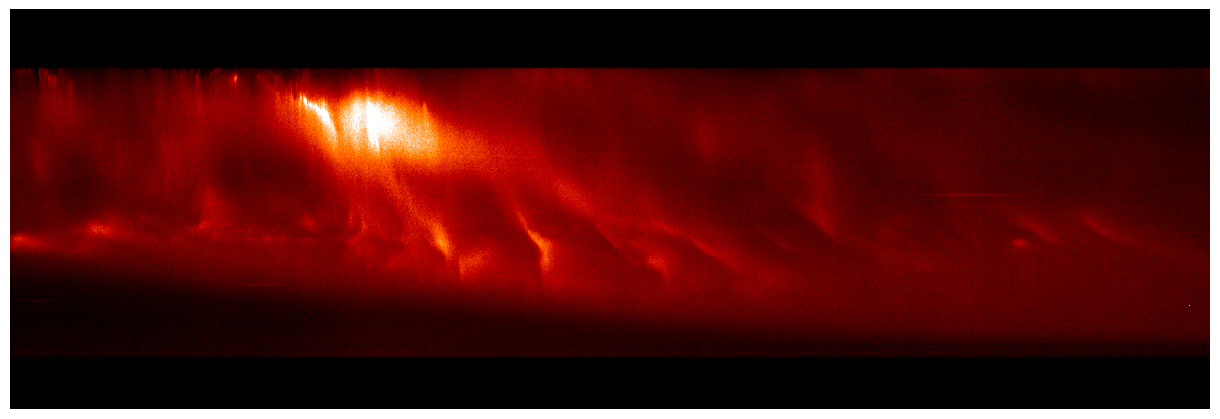

In [13]:
# we're going to continue using scaled images array of the hour of data, but 
# we'll scale it a bit differently first
images_scaled = at.scale_intensity(data.data, min=400, max=1300)

# create the keogram
keogram = at.keogram.create(images_scaled, data.timestamp)
print(keogram)

# display the keogram
at.display(keogram.data, cmap="gist_heat", figsize=(12, 4), aspect="auto")

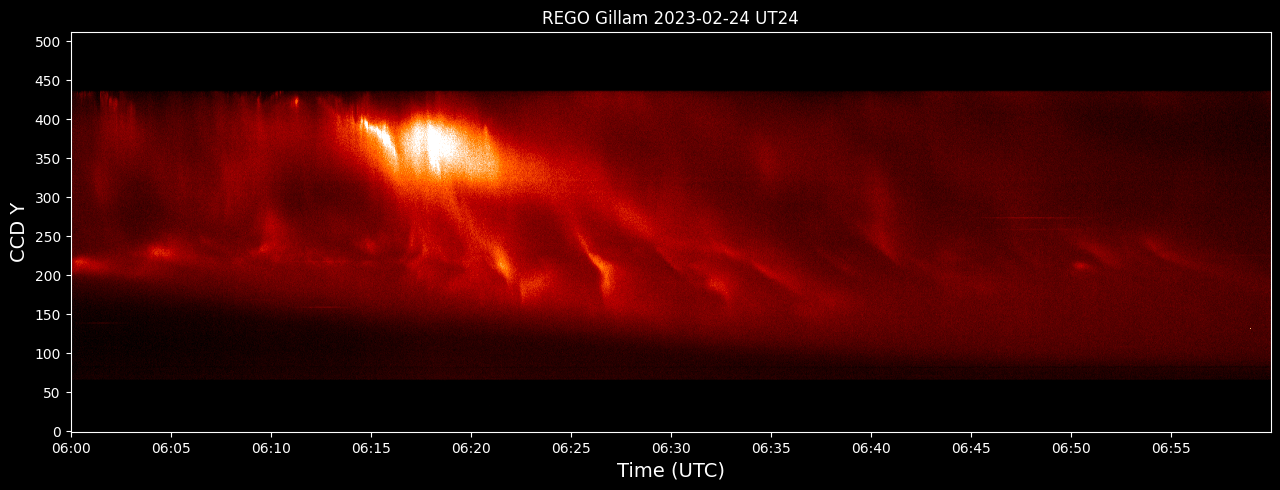

In [ ]:
# we can set matplotlib to use the dark theme, if we like that better
at.set_theme("dark")

# we'll add some text and axes to the plot
keogram.plot(
    title="REGO Gillam %s" % (data.timestamp[0].strftime("%Y-%m-%d UT%H")),
    figsize=(12, 4),
    cmap="gist_heat",
    aspect="auto",
)

---

## **Applying Dark Frame Corrections to Images**

For some optical systems, one may use the unexposed portion of the CCD to estimate dark counts, which essentially measure the total noise sources that are internal to the system. A typical way to do this is to take the average of the 5x5 array of pixels in the bottom corner of the image.

**Note**: this only works for detectors that have a uniform noise floor. This is the case for REGO, NASCAM, NIR, and THEMIS, but it is NOT the case for TREx-Blueline. Please see dedicated crib sheet (coming soon) for Blueline corrections.

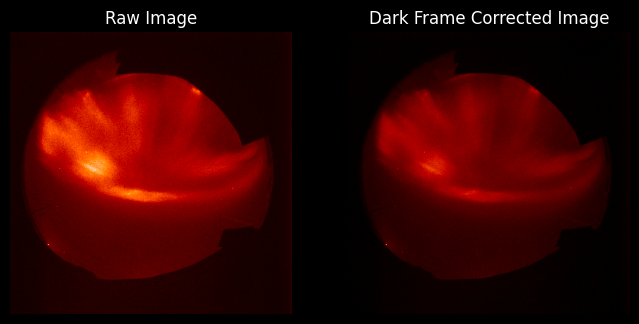

In [15]:
# we're going to perform the dark frame subtraction step ONLY here. By default, the 
# calibration routines perform all steps. But for the sake of progressive understanding 
# here, we'll do one bit at a time to start with.
images_bg_subtracted = at.calibration.rego(data.data, step_dark_frame_correction=True, step_flatfield_correction=False, step_rayleighs_conversion=False)

# as a sanity check, plot the two images scaled using the same floor and ceiling
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(8,4))
ax1.set_title("Raw Image")
ax1.imshow(at.scale_intensity(data.data[:,:,0], min=0, max=1000), cmap="gist_heat", origin="lower")
ax1.axis("off")
ax2.set_title("Dark Frame Corrected Image")
ax2.imshow(at.scale_intensity(images_bg_subtracted[:,:,0], min=0, max=1000), cmap="gist_heat", origin="lower")
ax2.axis("off")
plt.show()

It can be useful to monitor the dark counts for an imager over the course of an imaging period. If an instrument is functioning normally, the dark counts will be stable throughout the period.

We can plot the dark counts as a function of time, and then overplot the zenith counts which will give us an idea of the luminosity directly overhead, in order to make sure that the imager was functioning as expected. We'll use the same hour of data that we constructed the above keogram and ewogram with, which is still stored in the img variable.

In [16]:
# To begin, let's first determine the indices we need. For the dark counts,
# we once again want the bottom corner 5x5 array:
bottom_row_idx = int((data.data.shape[0]) - 1)

# For the zenith count, we want the center 5x5 array of the CCD:
middle_row_idx = int((data.data.shape[0])/2 - 1)
middle_column_idx = int((data.data.shape[1])/2 - 1)

# To index into the center 5x5 array, we will take advantage of array indexing using the
# center pixel indices. Let's test to make sure the dimensions are right:
test_center_array = data.data[middle_row_idx-2:middle_row_idx+3, middle_column_idx-2:middle_column_idx+3]

print("Centre Array Slice Dimensions: %d x %d" % (test_center_array.shape[0], test_center_array.shape[1]))

Centre Array Slice Dimensions: 5 x 5


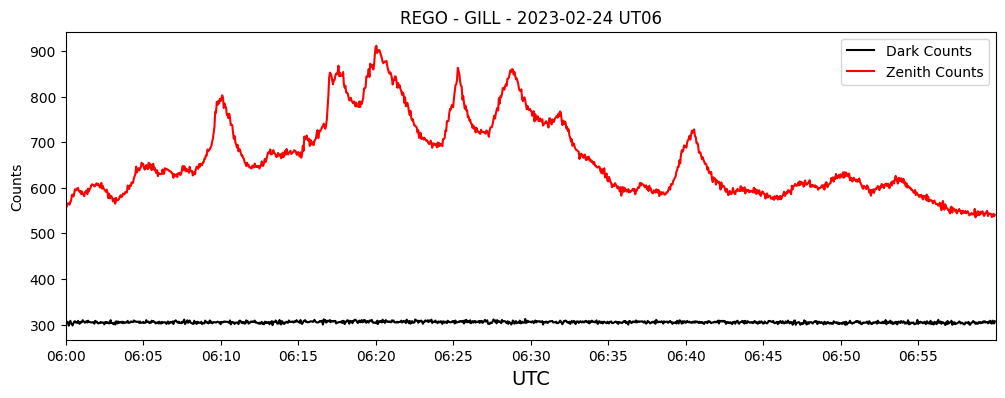

In [17]:
# Now that we know where to grab our samples from, we just need to iterate
# through all the images and compute the dark and zenith counts for each.
#
# switch back to default theme
at.set_theme("default")

# init some variables
dark_counts_list = []
zenith_counts_list = []
n_imgs = data.data.shape[-1]
data_project_name = data.metadata[0]["Project unique ID"].upper()
data_site_uid = data.metadata[0]["Site unique ID"].upper()

for img_idx in range(0, n_imgs):
    dark_counts = np.mean(data.data[bottom_row_idx-4:, 0:5, img_idx])
    zenith_counts = np.mean(data.data[middle_row_idx-2:middle_row_idx+3, middle_column_idx-2:middle_column_idx+3, img_idx])

    dark_counts_list.append(dark_counts)
    zenith_counts_list.append(zenith_counts)

# Now, we can simply plot the lists to see any variation over the hour:
plt.figure(figsize=(12,4))
plt.plot(dark_counts_list, color="black", label="Dark Counts")
plt.plot(zenith_counts_list, color="red", label="Zenith Counts")
plt.xlim(0,n_imgs)
plt.legend()
plt.title("%s - %s - %s" % (data_project_name, data_site_uid, data.timestamp[0].strftime("%Y-%m-%d UT%H")))
plt.xticks(np.arange(0,n_imgs, 100), [x.strftime("%H:%M") for x in data.timestamp][::100])
plt.ylabel("Counts")
plt.xlabel("UTC", fontsize=14)
plt.show()

# We should see that the dark counts are essentially constant throughout the imaging period
# whereas the zenith counts will spike up and down with auroral activity, as expected.

---
## **Radiometric Calibration**

When working with narrow band image data such as REGO, one may perform a radiometric calibration in order to convert the data to physical units (Rayleighs). To do so, one must first perform a flat-field calibration, using calibration files found on the data portal, that allow calibration based on inherent properties of the optical system.

In [18]:
# remember from earlier, we downloaded this data
print(r_ray.filenames)
print(r_flat.filenames)
print()

# let's read the data in
data_rayleighs = aurorax.data.ucalgary.read(r_ray.dataset, r_ray.filenames)
data_flatfield = aurorax.data.ucalgary.read(r_flat.dataset, r_flat.filenames)

# show what we read in
print(data_rayleighs)
print(data_flatfield)
print()
data_rayleighs.data[0].pretty_print()
print()
data_flatfield.data[0].pretty_print()

[PosixPath('/home/darrenc/pyaurorax_data/REGO_CALIBRATION_RAYLEIGHS_IDLSAV/REGO_Rayleighs_15652_20141102-+_v01.sav')]
[PosixPath('/home/darrenc/pyaurorax_data/REGO_CALIBRATION_FLATFIELD_IDLSAV/REGO_flatfield_15652_20141102-+_v01.sav')]

Data(data=[1 Calibration object], timestamp=[], metadata=[], problematic_files=[], calibrated_data=None, dataset=Dataset(name=REGO_CALIBRATION_RAYLEIGHS_IDLSAV, short_description='REGO All...))
Data(data=[1 Calibration object], timestamp=[], metadata=[], problematic_files=[], calibrated_data=None, dataset=Dataset(name=REGO_CALIBRATION_FLATFIELD_IDLSAV, short_description='REGO All...))

Calibration:
  dataset                       : Dataset(...)
  detector_uid                  : 15652
  filename                      : /home/darrenc/pyaurorax_data/REGO_CALIBRATION_RAYLEIGHS_IDLSAV/REGO_Rayleighs_15652_20141102-+_v01.sav
  flat_field_multiplier         : None
  generation_info               : CalibrationGenerationInfo(...)
  rayleighs_perdn_persecond     :

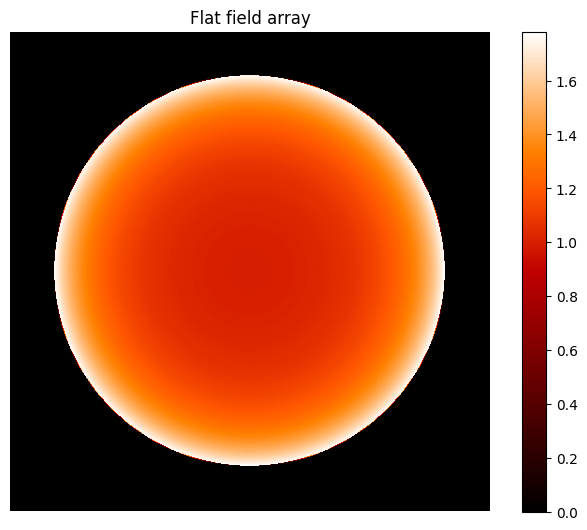

In [19]:
# display the flatfield array
at.display(data_flatfield.data[0].flat_field_multiplier, cmap='gist_heat', title="Flat field array", colorbar=True)

# The flat field array is essentially a multiplicative array to be applied to the image;
# one can see that at low elevation angles, this factor is higher, which is expected.

Now, we will perform the full calibration process: dark frame correction, flatfield correction, and rayleighs conversion. 

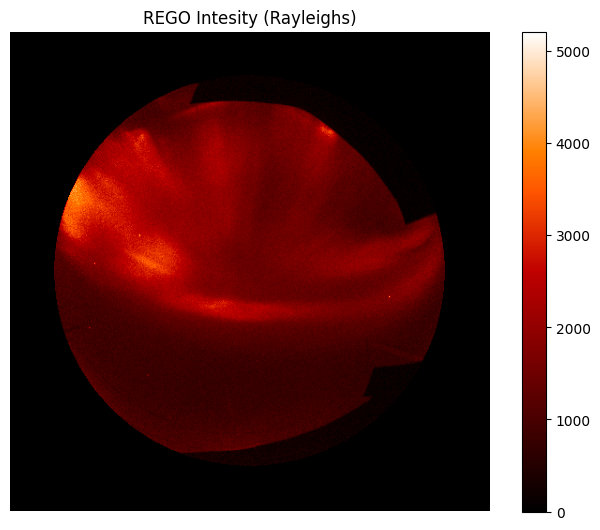

In [20]:
# run the calibration function for REGO. All 'steps' are performed by default.
data.calibrated_data = at.calibration.rego(data.data, cal_flatfield=data_flatfield.data[0], cal_rayleighs=data_rayleighs.data[0])

# display the Rayleighs calibrated data; we'll just show the first image
at.display(data.calibrated_data[:,:,0], title="REGO Intesity (Rayleighs)", colorbar=True, cmap="gist_heat")

If you want to scale the calibrated data, we can do that, but **make sure you realize what this is actually doing**.

We can put a max value of, say, 10000 Rayleighs on the array, but we MUST account for that in the colorbar. By applying a scaling ceiling to the data, it means that any image pixel with a maximum value could be actually be greater than that ceiling, which physically, is important to realize.

When scaling multiple imagers, and/or in a time sequence, it is essential to ensure that scaling is not introducing information into the data (e.g., scaling images differently as a function of time).

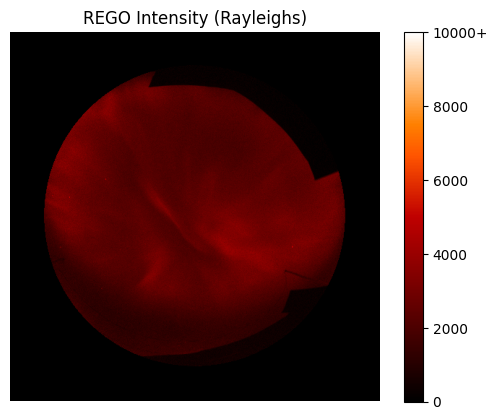

In [28]:
# Apply a scaling ceiling of 10000 R

# cap the scale at a certain Rayleighs
max_cutoff = 10000

# calibrate a single frame
calibrated_data_single_frame = at.calibration.rego(
    data.data[:, :, 600],
    cal_flatfield=data_flatfield.data[0],
    cal_rayleighs=data_rayleighs.data[0],
)
calibrated_data_single_frame[np.where(calibrated_data_single_frame > max_cutoff)] = max_cutoff

plt.imshow(calibrated_data_single_frame, cmap="gist_heat", vmin=0, vmax=max_cutoff, origin="lower")
plt.axis("off")
plt.title("REGO Intensity (Rayleighs)")

# Create a colorbar, in Rayleighs, that accounts for the scaling limit we applied
cbar_ticks = [float(max_cutoff) / 5. * j for j in range(0, 6)]
cbar_ticknames = [str(int(max_cutoff / 5) * j) for j in range(0, 6)]

# Any pixels with the max Rayleigh value could be greater than it, so we include the plus sign
cbar_ticknames[-1] += '+'
cbar = plt.colorbar(ticks=cbar_ticks)
cbar.ax.set_yticklabels(cbar_ticknames)
plt.show()

# By doing this, we are losing some information. For any pixel with values greater than
# or equal to 10,000, we can no longer know it's actual intensity, only that it is >= 10000 R.

**Remember, this method of radiometric calibration is valid <u>only</u> for narrow-band detectors.**  

It also assumes a detector with a linear response (which is true for REGO, NIR, NASCAM, and Blue).
